In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import util as utl

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "report"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

util loaded


# Load data

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)

In [3]:
housing.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
medinc = 'MedInc'
lat = 'Latitude'
lon = 'Longitude'

X = housing.data[[medinc,lat,lon]]

X

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25
...,...,...,...
20635,1.5603,39.48,-121.09
20636,2.5568,39.49,-121.21
20637,1.7000,39.43,-121.22
20638,1.8672,39.43,-121.32


# DBSCAN

In [30]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=0.2, min_samples=20)
labels = dbscan.fit_predict(X_scaled)

In [31]:
housing.data["Cluster"] = labels

In [32]:
dbscan.labels_[100:]

array([0, 0, 0, ..., 0, 0, 0], shape=(20540,))

In [33]:
len(dbscan.core_sample_indices_)

18570

In [34]:
dbscan.core_sample_indices_

array([    0,     1,     2, ..., 20636, 20638, 20639], shape=(18570,))

In [35]:
dbscan.components_

array([[ 2.34476576,  1.05254828, -1.32783522],
       [ 2.33223796,  1.04318455, -1.32284391],
       [ 1.7826994 ,  1.03850269, -1.33282653],
       ...,
       [-0.6915927 ,  1.80632866, -0.81872189],
       [-1.05458292,  1.77823747, -0.87362627],
       [-0.78012947,  1.75014627, -0.83369581]], shape=(18570, 3))

# Check labels

In [36]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [37]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise}")

Clusters found: 10
Noise points: 999


In [49]:
summary = housing.data.groupby("Cluster")[[medinc, "HouseAge", "AveRooms"]].mean()
summary["Count"] = housing.data["Cluster"].value_counts().sort_index()

summary

,MedInc,HouseAge,AveRooms,Count
Cluster,,,,
-1,5.065015,22.594595,7.850996,999
0,3.646653,29.234571,5.407526,8296
1,2.003445,24.900000,14.526140,20
2,3.019418,22.000000,12.589522,34
3,2.433417,32.796117,5.225339,103
4,1.876585,23.426230,4.701678,61
5,3.855374,28.904317,5.141502,10702
6,10.236264,24.761364,7.755455,88
7,15.000097,42.787879,8.846199,33


In [45]:
housing.data.groupby("Cluster")[[medinc, "HouseAge", "AveRooms"]].count()

,MedInc,HouseAge,AveRooms
Cluster,,,
-1,999,999,999
0,8296,8296,8296
1,20,20,20
2,34,34,34
3,103,103,103
4,61,61,61
5,10702,10702,10702
6,88,88,88
7,33,33,33


Saving figure visualize_cluster_geo


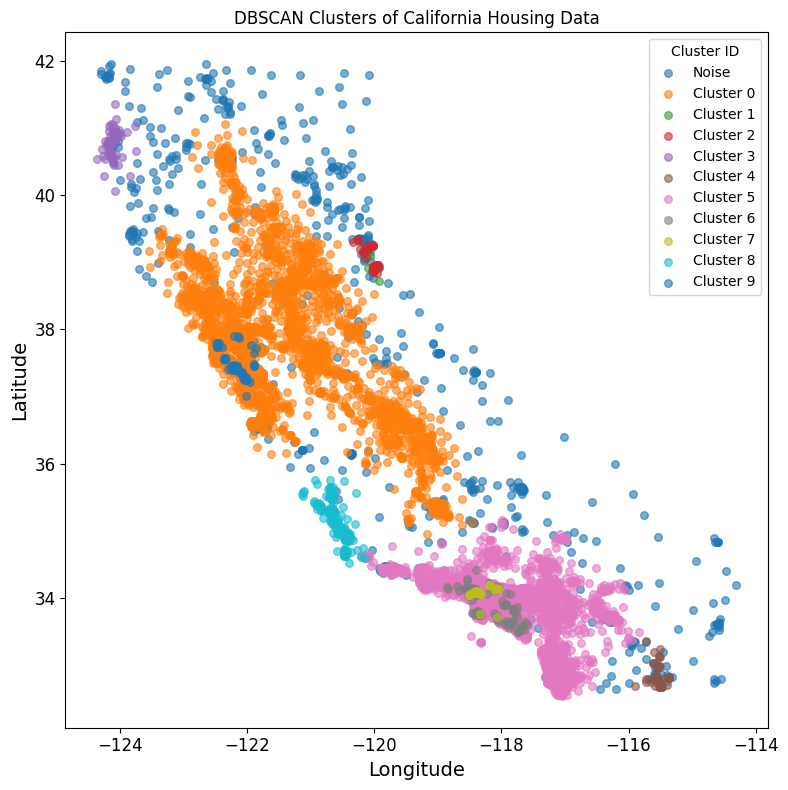

In [50]:
unique_clusters = np.unique(labels)

plt.figure(figsize=(8, 8))

for cluster in unique_clusters:
    subset = housing.data[labels == cluster]
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"
    plt.scatter(subset["Longitude"], subset["Latitude"], s=30, alpha=0.6, label=label)

plt.title("DBSCAN Clusters of California Housing Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster ID")
save_fig('visualize_cluster_geo')
plt.show()

Saving figure find_optimal_eps


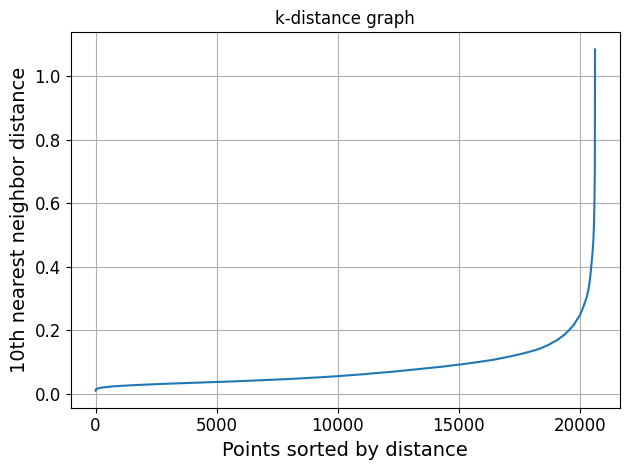

In [43]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.title("k-distance graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("10th nearest neighbor distance")
plt.grid(True)
save_fig('find_optimal_eps')
plt.show()